In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

In [2]:
def get_text(text_list):
    arr = []
    for t in text_list:
        arr.append(t.get_text())
    return " ".join(arr)

In [3]:
import json

years = ['2021', '2022', '2023']
driver = webdriver.Safari()

tmd_results_map = {}
tmd_no_results_map = {}

year_map = {}
no_year_map = {}
links = []

url = 'https://tmd.texas.gov/press-releases'
driver.get(url)
wait = WebDriverWait(driver, 100)

soup = BeautifulSoup(driver.page_source, 'html.parser')
nsoup = soup.find(class_="col-md-12 nomargins center-pane clearfix")
art_years = nsoup.find_all('div', class_='outerwrap')
art_years = art_years[0:12]

for art_year in art_years:
    year_map = {}
    no_year_map = {}
    links = []
    
    year = art_year.find('h2').text
    if year in years:
        print(year)
        links = art_year.find_all('a')
        
        for link in links:
            href = link.get('href')
            if href.startswith('https:/'):
                # Navigate to the page
                driver.get(href)

                # Extract the relevant text
                page_soup = BeautifulSoup(driver.page_source, 'html.parser')
                texts = page_soup.find_all('p')
                text = get_text(texts).lower()

                # Store the text in a map
                if "operation lone star" in text:
                    # print(href)
                    year_map[link.get_text().lower()] = text
                else:
                    # print("none")
                    no_year_map[link.get_text().lower()] = text
    
    


        with open(f"archive/TMD/OLS/{year}.json", "w") as outfile:
            # write the dictionary to the file as JSON
            json.dump(year_map, outfile)

        with open(f"archive/TMD/noOLS/{year}.json", "w") as outfile:
            # write the dictionary to the file as JSON
            json.dump(no_year_map, outfile)
    
        tmd_results_map[year] = year_map
        tmd_no_results_map[year] = no_year_map
            
driver.quit()  

WebDriverException: Message: 


Now lets look at how many articles we obtained from the TMD website

In [4]:
total = 0
for year in tmd_results_map:
    total = total + len(tmd_results_map[year])
print(total, "total articles containing \"Operation Lone Star\"")

total = 0
for year in tmd_no_results_map:
    total = total + len(tmd_no_results_map[year])
print(total, "total articles not containing \"Operation Lone Star\"")

11 total articles containing "Operation Lone Star"
21 total articles not containing "Operation Lone Star"


In [2]:
import json

years = ['2021', '2022', '2023']

tmd_results_map = {}
tmd_no_results_map = {}
for year in years:
    year_map = {}
    no_year_map = {}
    
    f = open(f'archive/TMD/OLS/{year}.json')
    data = json.load(f)
    tmd_results_map[year] = data

    f = open(f'archive/TMD/noOLS/{year}.json')
    data = json.load(f)
    tmd_no_results_map[year] = data
        
    

Here I just saved all the articles as individual text files

In [72]:
for year in tmd_results_map:
    count = 0
    for key in tmd_results_map[year]:
        with open(f"articles_txt/TMD/{year}/{count}.txt", 'w+') as outfile:
            outfile.write(f'{key}\n\n{tmd_results_map[year][key]}')
        count = count + 1

## Analysis of TMD articles

In [6]:
import nltk
from nltk import FreqDist

In [7]:
import numpy as np

years = ['2021', '2022', '2023']

tmd_results_dict = {}
for year in years:
    # print(results_map[year])
    text_year = " ".join(tmd_results_map[year].values())
    tmd_results_dict[f'{year}'] = text_year
        
# print(len(all_results_dict))
# print(all_results_dict.items())

dtype = np.dtype([
    ('id', int),
    ('date', object),
    ('text', object),
])

data_list = [(i, k, "".join(list(v))) for i, (k, v) in enumerate(tmd_results_dict.items())]

tmd_results_np = np.array(data_list, dtype=dtype)

print(tmd_results_np[2])

(2, '2023', '')


In [8]:
tmd_results_np['date']

array(['2021', '2022', '2023'], dtype=object)

In [13]:
def rep(s, words):
    for key in words:
        for value in words[key]:
            s = s.replace(value, key)
    return s

In [62]:
from nltk.tokenize import RegexpTokenizer
import re
from nltk.corpus import stopwords
from collections import defaultdict


stop_words = set(stopwords.words('english'))
new_words = {'texas', 'operation', 'lone', 'star', 'us', 'austin', 'https'}
stop_words = stop_words.union(new_words)

tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')

tmd_freqs = {}
pattern = [r'\btexas\smilitary\sdepartment\b', r'\barmy\snational\sguard\b', r'\bnational\sguard\b', 
           r'\department\sof\spublic\ssafety\b', r'\btexas\sair\snational\sguard\b', r'\bair\snational\sguard\b',
           r'\btexas\sstate\sguard\b']

# define words to replace
words_to_replace = {
    'dps': ['department of public safety', 'txdps', 'txdeptpublicsafety'],
    'abbot': ['governor', 'gov'],
    'biden': ['president'],
    'tmd': ['texas military department'],
    'national guard': ['txng', 'texas national guard', 'txarng', 'army national guard', 'txang', 'texas army national guard'],
    'state guard': ['txsg', 'texas state guard']
}

total_words = []


for _,d,t in tmd_results_np:
    t = rep(t, words_to_replace)
    words = tokenizer.tokenize(t)
    new_tokens = []
    #TODO: make code more readable
    for i in range(len(words)):
        if i < len(words)-2 and re.match(pattern[0], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-2 and re.match(pattern[1], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-1 and re.match(pattern[2], words[i] + " " + words[i+1]):
            new_tokens.append(words[i] + " " + words[i+1])
        elif i < len(words)-3 and re.match(pattern[3], words[i] + " " + words[i+1] + " " + words[i+2]+ " " + words[i+3]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2] + " " + words[i+3])
        elif i < len(words)-3 and re.match(pattern[4], words[i] + " " + words[i+1] + " " + words[i+2]+ " " + words[i+3]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2] + " " + words[i+3])
        elif i < len(words)-2 and re.match(pattern[5], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-2 and re.match(pattern[6], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        else:
            new_tokens.append(words[i])
        
    filtered_tokens = [token for token in new_tokens if token not in stop_words]
    total_words.append(len(new_tokens))
    fdist = FreqDist(filtered_tokens)
    tmd_freqs[d] = fdist

for k, v in tmd_freqs.items():
    print(k, ':')
    for word, frequency in v.most_common(30):
        print(f"{word}: {frequency}")
    print()
        

2021 :
dps: 12
tmd: 6
border: 5
media: 4
secure: 4
state: 4
abbot: 3
agencies: 3
share: 3
provide: 3
briefing: 2
ols: 2
abbott: 2
southern: 2
briefings: 2
officials: 2
partner: 2
human: 2
one: 2
local: 2
protecting: 2
communities: 2
across: 2
said: 2
also: 2
preventing: 2
federal: 2
illegal: 2
texans: 2
always: 2

2022 :
tmd: 93
guard: 72
state: 69
national guard: 54
abbot: 33
office: 29
support: 26
media: 25
military: 25
information: 23
public: 23
service: 19
mission: 18
members: 15
soldier: 14
pay: 14
adjutant: 13
general: 13
federal: 13
contact: 12
release: 12
border: 12
download: 11
affairs: 11
click: 10
immediate: 10
provide: 10
ready: 10
trained: 10
home: 10

2023 :



In [79]:
tmd_freqs['2022']['tmd, texas military department'] = tmd_freqs['2022']['tmd'] + tmd_freqs['2022']['texas military department']
tmd_freqs['tmd'] = 0
tmd_freqs['texas military department'] = 0

In [53]:
type(tmd_freqs['2021'])

nltk.probability.FreqDist

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
tmd_top_perc_2021 = [(k ,(v/total_words[0])*100) for k, v in tmd_top_words_2021]


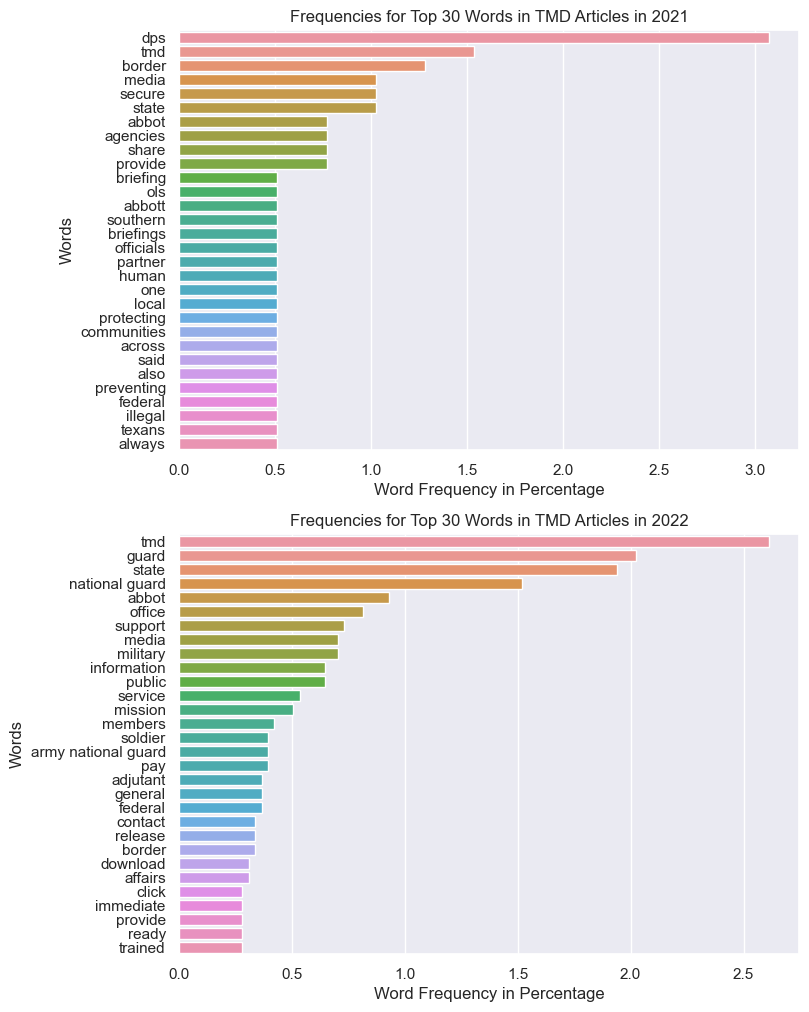

In [46]:
tmd_top_words_2021 = [(k ,(v/total_words[0])*100) for k, v in tmd_freqs['2021'].most_common(30)]
tmd_top_words_2022 = [(k ,(v/total_words[1])*100) for k, v in tmd_freqs['2022'].most_common(30)]


# Create a bar plot of the most common words
fig, axes = plt.subplots(2,1,figsize=(8,12))
sns.set(style="darkgrid")
plot_2021 = sns.barplot(ax = axes[0], 
                        x=[w[1] for w in tmd_top_words_2021], 
                        y=[w[0] for w in tmd_top_words_2021])
plot_2021.set(xlabel='Word Frequency in Percentage',
              ylabel='Words',
              title='Frequencies for Top 30 Words in TMD Articles in 2021')


plot_2022 = sns.barplot(ax = axes[1], 
                        x=[w[1] for w in tmd_top_words_2022], 
                        y=[w[0] for w in tmd_top_words_2022])
plot_2022.set(xlabel='Word Frequency in Percentage',
              ylabel='Words',
              title='Frequencies for Top 30 Words in TMD Articles in 2022')
plt.show()


In [63]:
tmd_all_text = " ".join(tmd_results_np['text'])
                    
tmd_all_text = rep(tmd_all_text, words_to_replace)
tmd_words = tokenizer.tokenize(tmd_all_text)
new_tokens = []
#TODO: make code more readable
for i in range(len(tmd_words)):
    if i < len(tmd_words)-2 and re.match(pattern[0], tmd_words[i] + " " + tmd_words[i+1]+ " " + tmd_words[i+2]):
        new_tokens.append(tmd_words[i] + " " + tmd_words[i+1] + " " + tmd_words[i+2])
    elif i < len(tmd_words)-2 and re.match(pattern[1], tmd_words[i] + " " + tmd_words[i+1]+ " " + tmd_words[i+2]):
        new_tokens.append(tmd_words[i] + " " + tmd_words[i+1] + " " + tmd_words[i+2])
    elif i < len(tmd_words)-1 and re.match(pattern[2], tmd_words[i] + " " + tmd_words[i+1]):
        new_tokens.append(tmd_words[i] + " " + tmd_words[i+1])
    elif i < len(tmd_words)-3 and re.match(pattern[3], tmd_words[i] + " " + tmd_words[i+1] + " " + tmd_words[i+2]+ " " + tmd_words[i+3]):
        new_tokens.append(tmd_words[i] + " " + tmd_words[i+1] + " " + tmd_words[i+2] + " " + tmd_words[i+3])
    elif i < len(tmd_words)-3 and re.match(pattern[4], tmd_words[i] + " " + tmd_words[i+1] + " " + tmd_words[i+2]+ " " + tmd_words[i+3]):
        new_tokens.append(tmd_words[i] + " " + tmd_words[i+1] + " " + tmd_words[i+2] + " " + tmd_words[i+3])
    elif i < len(tmd_words)-2 and re.match(pattern[5], tmd_words[i] + " " + tmd_words[i+1]+ " " + tmd_words[i+2]):
        new_tokens.append(tmd_words[i] + " " + tmd_words[i+1] + " " + tmd_words[i+2])
    elif i < len(tmd_words)-2 and re.match(pattern[6], tmd_words[i] + " " + tmd_words[i+1]+ " " + tmd_words[i+2]):
        new_tokens.append(tmd_words[i] + " " + tmd_words[i+1] + " " + tmd_words[i+2])
    else:
        new_tokens.append(tmd_words[i])
            
tmd_filtered_tokens = [token for token in new_tokens if token not in stop_words]
tmd_fdist = FreqDist(tmd_filtered_tokens)



for word, frequency in tmd_fdist.most_common(10):
    print(f"{word}: {frequency}")

tmd: 99
state: 73
guard: 73
national guard: 54
abbot: 36
media: 29
office: 29
support: 27
military: 25
public: 24


[Text(0.5, 0, 'Word Frequency in Percentage'),
 Text(0, 0.5, 'Words'),
 Text(0.5, 1.0, 'Frequencies for Top 30 Words in TMD Articles (2021-2023)')]

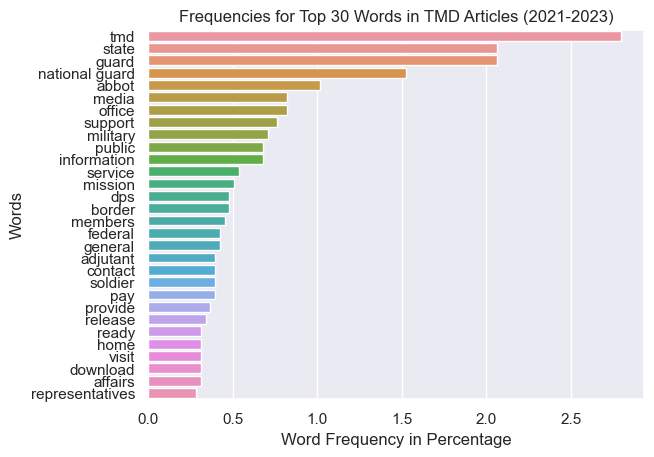

In [64]:
tmd_top_words = [(k ,(v/total_words[1])*100) for k, v in tmd_fdist.most_common(30)]


# Create a bar plot of the most common words
sns.set(style="darkgrid")
plot_all = sns.barplot(x=[w[1] for w in tmd_top_words], y=[w[0] for w in tmd_top_words])
plot_all.set(xlabel='Word Frequency in Percentage',
              ylabel='Words',
              title='Frequencies for Top 30 Words in TMD Articles (2021-2023)')

Lets create some word clouds

In [61]:
tmd_dict

{'tmd': 99,
 'state': 73,
 'guard': 73,
 'national guard': 54,
 'abbot': 36,
 'media': 29,
 'office': 29,
 'support': 27,
 'military': 25,
 'public': 24,
 'information': 24,
 'service': 19,
 'mission': 18,
 'dps': 17,
 'border': 17,
 'members': 16,
 'federal': 15,
 'general': 15,
 'adjutant': 14,
 'contact': 14,
 'soldier': 14,
 'army national guard': 14,
 'pay': 14,
 'provide': 13,
 'release': 12,
 'ready': 11,
 'home': 11,
 'visit': 11,
 'download': 11,
 'affairs': 11,
 'representatives': 10,
 'director': 10,
 'personnel': 10,
 'click': 10,
 'immediate': 10,
 'trained': 10,
 'abroad': 10,
 'comprised': 10,
 'connect': 10,
 'requests': 9,
 'wishing': 9,
 'obtain': 9,
 'assigned': 9,
 'biden': 9,
 'forces': 9,
 'citizens': 9,
 'civil': 9,
 'authorities': 9,
 'commanded': 9,
 'senior': 9,
 'official': 9,
 'appointed': 9,
 'administration': 9,
 'formerly': 9,
 'executive': 9,
 'texas air national guard': 9,
 'air national guard': 9,
 'website': 9,
 'servicemembers': 8,
 'hardship': 8,
 '

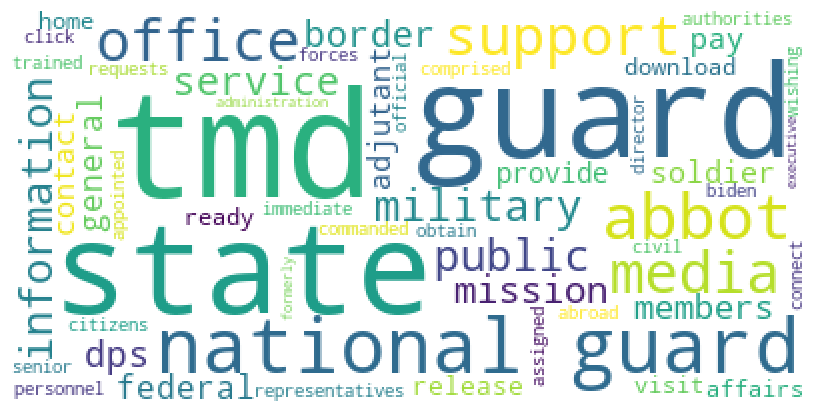

In [76]:
from wordcloud import WordCloud

#TODO: keep combined words together
tmd_top_words = tmd_fdist.most_common(75)
tmd_dict = {}
for k, v in tmd_top_words:
    tmd_dict[k] = v
# text = ""
# for word, _ in tmd_top_words:
#     word = word.replace(" ", '-')
#     text += word + " "

word_cloud = WordCloud(min_font_size=7, background_color = 'white').generate_from_frequencies(tmd_dict)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

In [70]:
text = ""
for word, _ in tmd_top_words:
    text += word + "\n"
with open(f"Top_75/Tmd_top75.txt", 'w+') as outfile:
    outfile.write(text)